## Cameron Roehlk
## ABE 516X
## PCA Guided Task
This notebook can be found on GitHub under isu-abe/516x/croehlk named Roehlk-PCA-Guided-Task.ipynb

## Pricipal Coordinate Analysis (PCA)

At times, when you're working with complex data, you have so many variables that you're not sure where to start...It's in these cases, when you have many variables to consider that I often turn to PCA.

In these situations of variable-overload, I often struggle to understand the relationships between each variable.  Am I overfitting a model -- its hard to tell with so many variables?  I'm also often concerned that I may be violating assumptions of a model, especially that featurse are independent. 

PCA helps to reduce the dimension of your feature space. By reducing the dimension of your feature space, you have fewer relationships between variables to consider and you are less likely to overfit your model. (Note: This doesn’t immediately mean that overfitting, etc. are no longer concerns!)

Reducing the dimension of the feature space is called more officially “dimensionality reduction.” There are many ways to achieve dimensionality reduction, but most of these techniques fall into one of two classes:

* Feature Elimination
* Feature Extraction

Feature elimination is what it sounds like: we reduce the feature space by eliminating features.  Instead of considering all 100 features, we'll only use 10. Advantages of feature elimination methods include simplicity and maintaining interpretability of your variables. As a disadvantage, though, you gain no information from those variables you’ve dropped (and they may be important!).

Feature extraction, however, doesn’t run into this problem. Say we have ten independent variables. In feature extraction, we create ten “new” independent variables, where each “new” independent variable is a combination of each of the ten “old” independent variables. However, we create these new independent variables in a specific way and order these new variables by how well they predict our dependent variable.  In the Statquest video, these were the fitted eigenvectors he discussed.

Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables! As an added benefit, each of the “new” variables after PCA are all independent of one another. This is a benefit because the assumptions of a linear model require our independent variables to be independent of one another. If we decide to fit a linear regression model with these “new” variables, this assumption will necessarily be satisfied.

#### When should PCA be used?

* Do you want to reduce the number of variables, but aren’t able to identify variables to completely remove from consideration?
* Do you want to ensure your variables are independent of one another?
* Are you comfortable making your independent variables less interpretable?

If you answered “yes” to all three questions, then PCA is a good method to use. If you answered “no” to question 3, you should not use PCA.

Content based on https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

### Dataset for PCA

We are going to be working with the digital images of tumor cells from our previous SVM tutorial.  You'll remember that we have tumor images to predict whether the tumors are malignant or benign.

For each image, ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

Additionally, the mean, standard error and “worst” or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features.  

Let's start with bringing in the dataset and taking a quick look at it....

In [1]:
%matplotlib inline

In [2]:
import pandas as pd

dataset = pd.read_csv('../data/cancer.csv')

In [3]:
dataset.head

<bound method NDFrame.head of            ID diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M       17.990         10.38          122.80     1001.0   
1      842517         M       20.570         17.77          132.90     1326.0   
2    84300903         M       19.690         21.25          130.00     1203.0   
3    84348301         M       11.420         20.38           77.58      386.1   
4    84358402         M       20.290         14.34          135.10     1297.0   
5      843786         M       12.450         15.70           82.57      477.1   
6      844359         M       18.250         19.98          119.60     1040.0   
7    84458202         M       13.710         20.83           90.20      577.9   
8      844981         M       13.000         21.82           87.50      519.8   
9    84501001         M       12.460         24.04           83.97      475.9   
10     845636         M       16.020         23.24          102.70      797.8  

In [4]:
dataset.shape

(569, 32)

In [5]:
print(dataset.columns)

Index(['ID', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'conc_mean',
       'conc_points_mean', 'symmetry_mean', 'fractral_mean', 'radius_se',
       'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'conc_se', 'conc_points_se', 'symmetry_se',
       'fractral_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'compactness_worst', 'conc_worst',
       'conc_points_worst', 'symmetry_worst', 'fractral_worst'],
      dtype='object')


Let's select the mean, errors, and worst columns as separate dataframes.  We've done this several different ways, usign iloc, using specific column names.  This method is probably one I use a lot.

In [6]:
feature_mean = list(dataset.columns[2:12])
feature_errors = list(dataset.columns[12:22])
feature_worst = list(dataset.columns[22:32])

In [7]:
dataset_mean = dataset[feature_mean]

In [8]:
dataset_mean.corr(method='pearson')

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,conc_mean,conc_points_mean,symmetry_mean,fractral_mean
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369
conc_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783
conc_points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921
fractral_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000


In [9]:
print(feature_mean, feature_errors, feature_worst)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'conc_mean', 'conc_points_mean', 'symmetry_mean', 'fractral_mean'] ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'conc_se', 'conc_points_se', 'symmetry_se', 'fractral_se'] ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'conc_worst', 'conc_points_worst', 'symmetry_worst', 'fractral_worst']


Make a correlation plot of the average values.

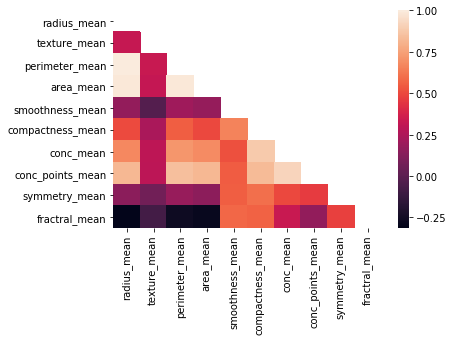

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#This removes the tophald redundancies in the heatmap
corr = dataset_mean.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(corr, mask=mask)

On your Own:  Make at least one other plot to explore the correlations within this dataset.

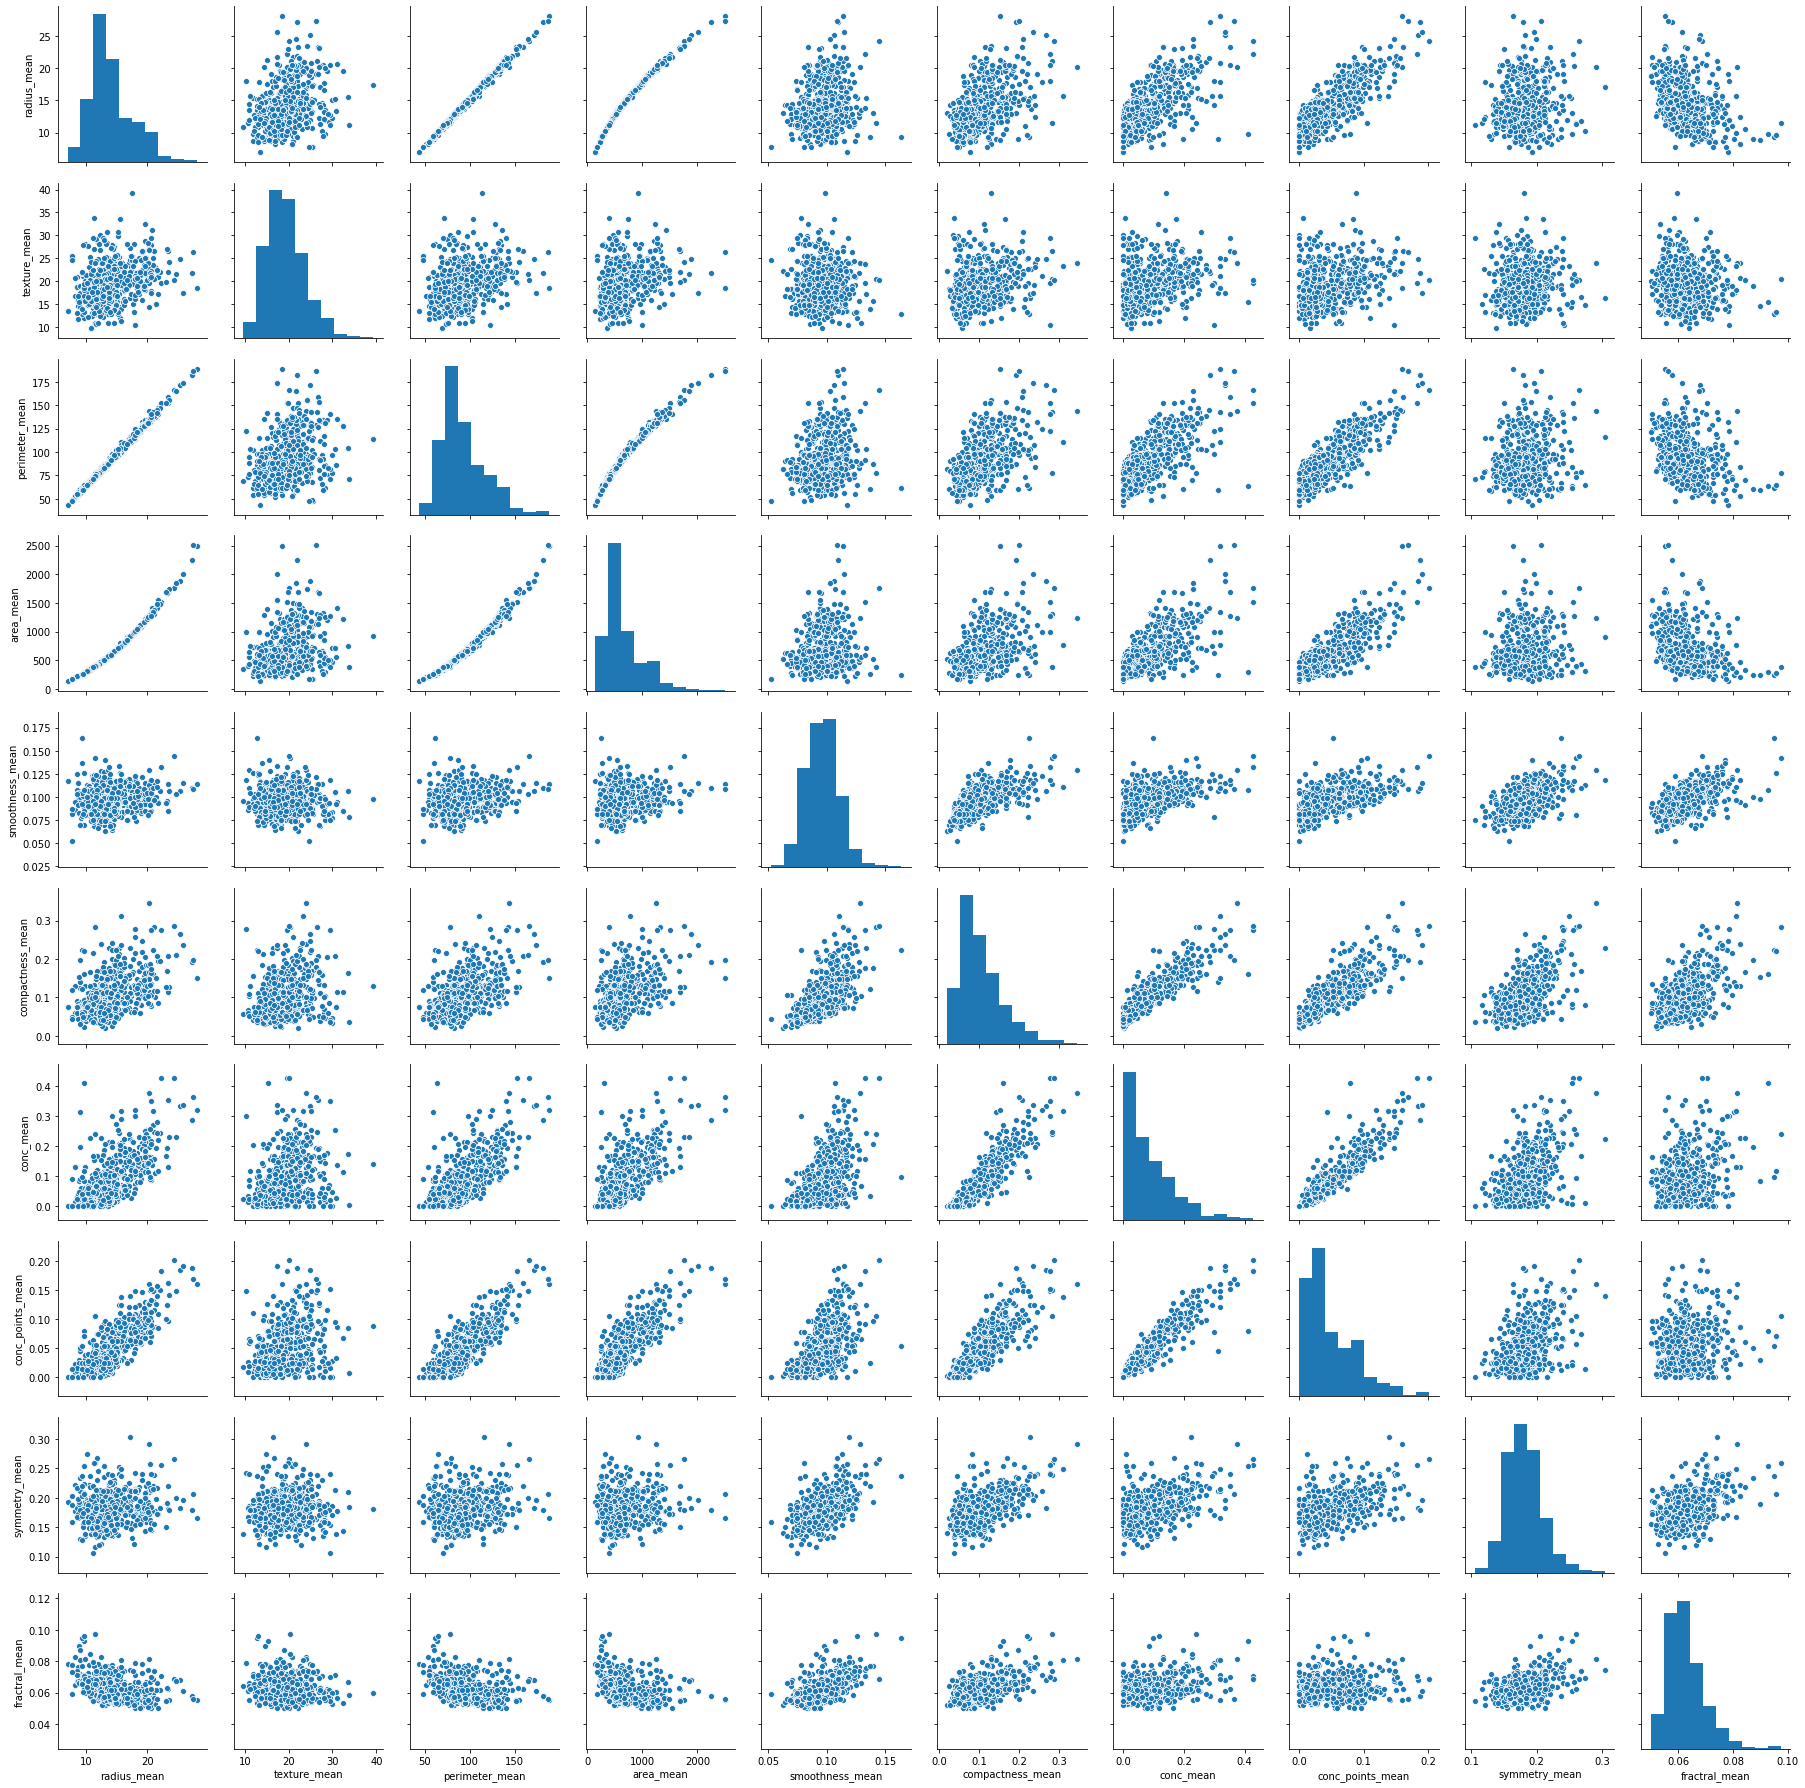

In [12]:
sns.pairplot(dataset_mean, kind = "scatter")
plt.show()

From the heat map and the pairplot, there are a lot of positive correlations in the dataset. The highest correlation being between radius mean and perimeter mean.

###  Scaling data is important for PCAs

Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

While many algorithms (such as SVM, K-nearest neighbors, and logistic regression) require features to be normalized.  Principle Component Analysis (PCA) is a prime example of when normalization is also important. 

In PCA we are interested in the components that maximize the variance. If one component (e.g. human height) varies less than another (e.g. weight) because of their respective scales (meters vs. kilos), PCA might determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis, if those features are not scaled. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, this is clearly incorrect.

[Source Documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [13]:
from sklearn.preprocessing import StandardScaler

X_data = dataset.iloc[:,2:32]
Y_data = dataset.iloc[:,1]

scaled_data = StandardScaler()
scaled_X = scaled_data.fit_transform(X_data)

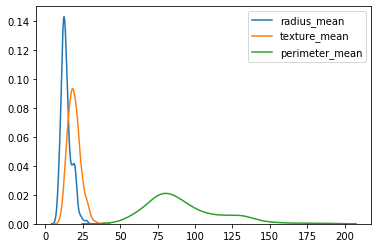

In [14]:
sns.kdeplot(X_data.iloc[:,0])
sns.kdeplot(X_data.iloc[:,1])
sns.kdeplot(X_data.iloc[:,2])

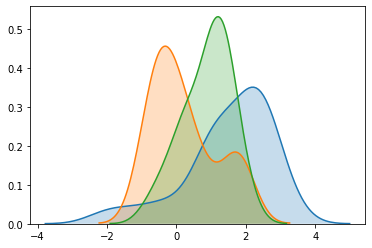

In [15]:
sns.kdeplot(scaled_X[0], shade = True)
sns.kdeplot(scaled_X[1], shade = True)
sns.kdeplot(scaled_X[2], shade = True)

In the code above, what do the arguments 'stratify' and 'random_state' specify and when might you use them?

Stratify is used when we want to split the entire data set into smaller groups. Random state is used as a seed to the random number generator. This ensures that the data we divide into smaller groups are reproducible.

In [75]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components = 4)
pca1.fit(scaled_X)
trained_pca1 = pca1.transform(scaled_X)

In [76]:
trained_pca1.shape

(569, 4)

In [77]:
pc_df = pd.DataFrame(data = trained_pca1, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
pc_df

,PC1,PC2,PC3,PC4
0,9.192837,1.948583,-1.123166,3.633731
1,2.387802,-3.768172,-0.529293,1.118264
2,5.733896,-1.075174,-0.551748,0.912083
3,7.122953,10.275589,-3.232790,0.152547
4,3.935302,-1.948072,1.389767,2.940639
5,2.380247,3.949929,-2.934877,0.941037
6,2.238883,-2.690031,-1.639913,0.149340
7,2.143299,2.340244,-0.871947,-0.127043
8,3.174924,3.391813,-3.119986,-0.601297
9,6.351747,7.727174,-4.341916,-3.375202


In [85]:
pc_df['Cluster'] = Y_data
pc_df

,PC1,PC2,PC3,PC4,Cluster
0,9.192837,1.948583,-1.123166,3.633731,M
1,2.387802,-3.768172,-0.529293,1.118264,M
2,5.733896,-1.075174,-0.551748,0.912083,M
3,7.122953,10.275589,-3.232790,0.152547,M
4,3.935302,-1.948072,1.389767,2.940639,M
5,2.380247,3.949929,-2.934877,0.941037,M
6,2.238883,-2.690031,-1.639913,0.149340,M
7,2.143299,2.340244,-0.871947,-0.127043,M
8,3.174924,3.391813,-3.119986,-0.601297,M
9,6.351747,7.727174,-4.341916,-3.375202,M


Let's take a look at our trained dataset and how much was explained by each principle coordinate.

In [78]:
pca1.explained_variance_ratio_

array([0.44272026, 0.18971182, 0.09393163, 0.06602135])

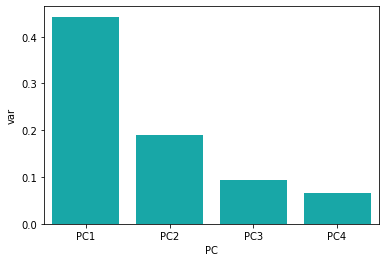

In [79]:
df = pd.DataFrame({'var':pca1.explained_variance_ratio_, 'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC', y="var", data=df, color="c");

From the bar plot, PC1 has the most variance with 44% followed by PC2 with 19% variance

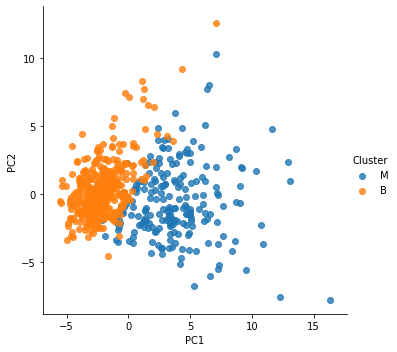

In [86]:
p = sns.lmplot(x = "PC1", y = "PC2", data = pc_df, fit_reg = False, hue="Cluster", legend = True)


Looking at plot above we can see that the two princpal components split the data pretty well.

Some other tutorials (that are potentially useful):

1.  PCA followed by regression:  https://nirpyresearch.com/principal-component-regression-python/
2.  Manually doing a PCA, more math theory: https://sebastianraschka.com/Articles/2014_pca_step_by_step.html
3.  Generic PCA with a different dataset:  https://medium.com/district-data-labs/principal-component-analysis-with-python-4962cd026465